In [1]:
from AutoEncoder import AutoEncoder
from trainingconstants import BATCH_SIZE
import torch
import pandas as pd
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

C:\Users\mwojc\AppData\Local\Temp\ipykernel_9276\2376123643.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def load_data(path):
    test_data = pd.read_csv(path)
    test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32)
    test_dataset = data.TensorDataset(test_data_tensor, test_data_tensor)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)
    return test_loader

In [3]:
def evaluate(data):
    predictions = []
    target = []
    losses = []
    
    model.eval()
    with torch.no_grad():
        for inputs, _ in data:
            output = model(inputs)
            test_losses = loss_fn(output, inputs)
            losses.extend(test_losses.sum(dim=1).detach().cpu().numpy())
            predictions.extend(output.cpu().numpy())
            target.extend(inputs.cpu().numpy())

    return predictions, target, losses

In [4]:
train_data_shape_1 = 140
model = AutoEncoder(train_data_shape_1)  
model.load_state_dict(torch.load('model.pth'))
loss_fn = nn.MSELoss(reduction='none')

In [5]:
normal_train_data = load_data("processedDataModified/X_normal_train.csv")

In [6]:
predictions_normal_train, target_normal_train, _ = evaluate(normal_train_data)

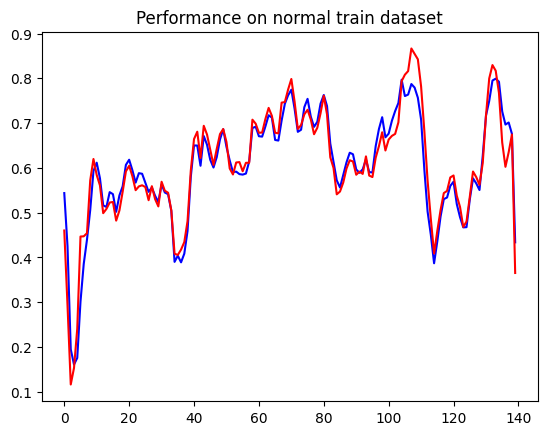

In [7]:
plt.plot(predictions_normal_train[1], 'b')
plt.plot(target_normal_train[1], 'r')
plt.title("Performance on normal train dataset")
plt.show()

In [8]:
anomalous_data = load_data("processedDataModified/X_anomalies_train.csv")

In [9]:
predictions_anomaly, target_anomaly, anomaly_loss = evaluate(anomalous_data)

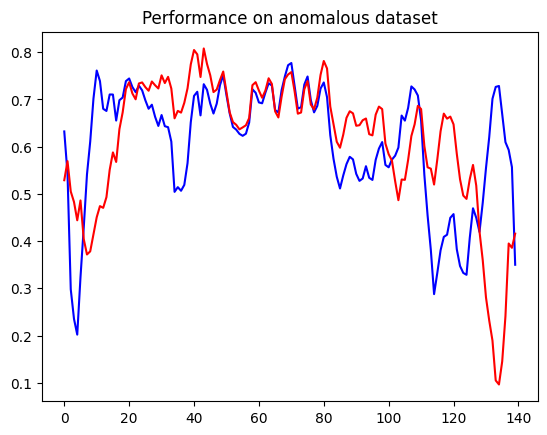

In [10]:
plt.plot(predictions_anomaly[0], 'b')
plt.plot(target_anomaly[0], 'r')
plt.title("Performance on anomalous dataset")
plt.show()

In [11]:
normal_test_data = load_data("processedDataModified/X_normal_test.csv")

In [12]:
predictions_normal_test, target_normal_test, normal_test_loss = evaluate(normal_test_data)
threshold = np.mean(normal_test_loss) + 2*np.std(normal_test_loss)

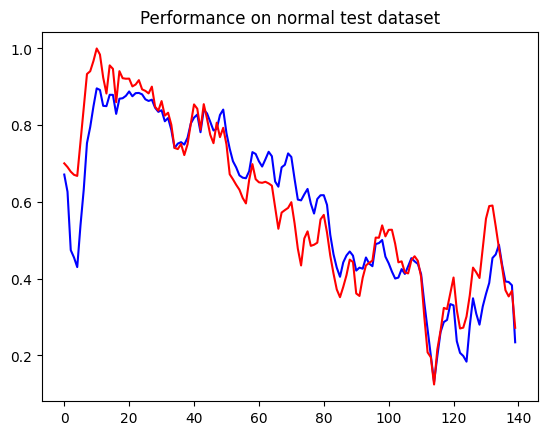

In [13]:
plt.plot(predictions_normal_test[0], 'b')
plt.plot(target_normal_test[0], 'r')
plt.title("Performance on normal test dataset")
plt.show()

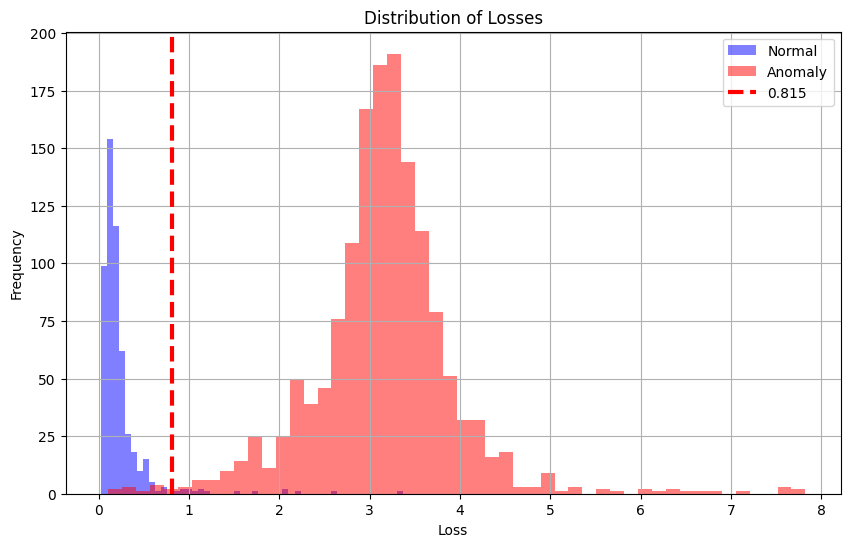

In [14]:
plt.figure(figsize=(10, 6))

plt.hist(normal_test_loss, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(anomaly_loss, bins=50, alpha=0.5, color='red', label='Anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Losses')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
true_labels = [0] * len(normal_test_loss) + [1] * len(anomaly_loss)
predicted_labels = [0 if loss <= threshold else 1 for loss in normal_test_loss + anomaly_loss]
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy {accuracy}")
print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Anomaly']))


Accuracy 0.9871478002965892
              precision    recall  f1-score   support

      Normal       0.98      0.97      0.98       525
     Anomaly       0.99      0.99      0.99      1498

    accuracy                           0.99      2023
   macro avg       0.99      0.98      0.98      2023
weighted avg       0.99      0.99      0.99      2023

